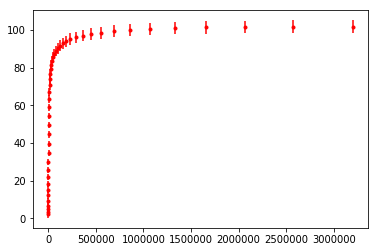

Figure 1: data


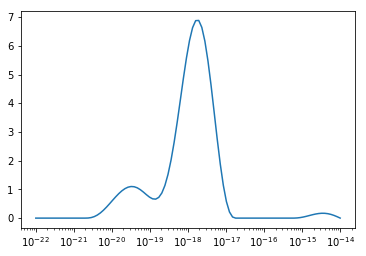

Figure 2: moment distribution prM


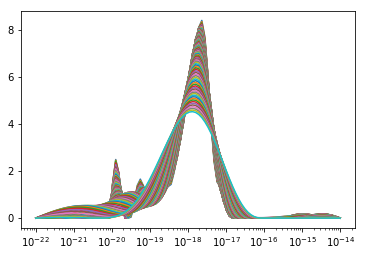

Figure 3: all distributions


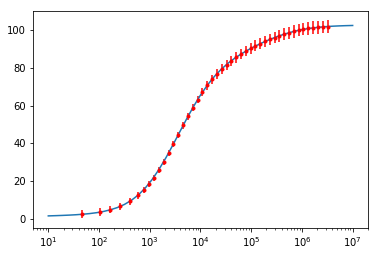

Figure 4: Data (red points) and fit (blue line)


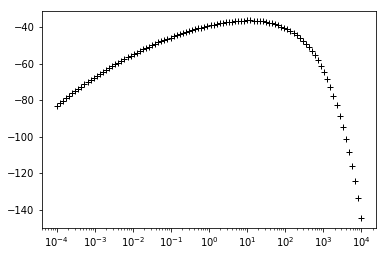

Figure 5: evidence vs alpha.


In [2]:
# In this notebook the moment distribution is extracted from the isothermal magnetization measurement 
# of a sample of (pseudo-)superparamagnetic nanoparticles
# by a regularized numerical inversion using the Langevin-function as model function
# The results are published in: 
# "Influence of clustering on the magnetic properties and hyperthermia performance of iron oxide nanoparticles"
# https://doi.org/10.1088/1361-6528/aad67d

#==============================================================================
# Import of used packages
from numpy.linalg import slogdet
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import nnls
#==============================================================================
# Import of the data (field in [A/m], magnetization in [Am^2/kg_Fe], sd in [Am^2/kg_Fe])

H,m,sd=np.genfromtxt("../data/FSL-DCM_data.txt", unpack=True, usecols = (0, 1, 2), skip_header=0, skip_footer=0)
        
mu0 = np.pi*4e-7 # Vacuum permeability [V*s/(A*m)]
T = 298.15 # Temperature [K]
kb = 1.38e-23 # Boltzmann constant [J/K]
NH=len(H)

sd_sq   = pow(sd,2)         
sdnorm  = 1/sd            
sdnorm = NH * sdnorm/sdnorm.sum()
sdmat = np.diag(sdnorm)
sdcol  = sdnorm[:,np.newaxis]            

M = m.dot(sdmat) # normalize data by sigma

#==============================================================================
# Definition of moment distribution

N=100# number of points of moment distribution
muList = np.logspace(-22,-14,N)   # Moment distrbution with lognormal spacing

#==============================================================================
# generate list for regularization parameter a

Na=100
aList=np.logspace(-4,4,Na)

#==============================================================================
# Plot data

plt.errorbar(H,m,sd,color='r',marker='.',ls='None',label='Observed')
plt.show()
print('Figure 1: data')   

#==============================================================================
# regularization matrices

L=0.5*(-1*np.eye(N,k=-1)+2*np.eye(N,k=0)-1*np.eye(N,k=1))
L[0,1] = 0
L[N-1,N-2] = 0

#==============================================================================
# Definition of function to generate the system matrix

def Aij(H, mu): # Langevin function
    y= (1/(np.tanh(mu*mu0*H/(kb*T)))-1/(mu*mu0*H/(kb*T)))
    return y

#==============================================================================
# Inversion of data
     
evList=[] 
prList=[]   

X = np.hstack([M, np.zeros(N)]) 

Hmat=np.tile(H,(N,1)).T
muListmat=np.tile(muList,(NH,1))

K = Aij(Hmat, muListmat) # Transfer matrix is determined
K=np.asarray(K) 

B = (K.T).dot(K*pow(sdcol,2))    

for ai in range(len(aList)):                                  
    # stacking of matrices            
    C = np.vstack([K*sdcol,np.sqrt(2*aList[ai])*L])            
    
    # Fit: non-negative constraint
    pr,resnorm=nnls(C,X)    
    
    # determine chisquare            
    Ifit=K.dot(pr)    
    chisq=(pow(m-Ifit,2)/sd_sq).sum()              

    # calculation of evidence
    S=sum(pow(L.dot(pr),2))
    Lsq=pow(L,2)
    U=2*Lsq+B/aList[ai] 
    detsign,rlogdet=slogdet(U)
    G=-aList[ai]*S-0.5*chisq            
    evidence=(G-0.5*rlogdet) # log of evidence    
        
    evList.append(evidence)       
    prList.append(pr)        

MAX=evList.index(max(evList)) # find maximal evidence
prM=prList[MAX] # moment distribution for which highest evidence was calculated

prList2=np.reshape(prList,(Na,N))         

H0=np.logspace(1,7,NH)
H0mat=np.tile(H0,(N,1)).T

KM0 = Aij(H0mat, muListmat)
KM0 = np.asarray(KM0)
fitM=KM0.dot(prM) # fitting curve (reconstructed for prM)

#==============================================================================
# Plots

plt.plot(muList,prM)
plt.xscale('log')
plt.show()
print('Figure 2: moment distribution prM')

plt.figure()
for i in range(Na):
    plt.xscale('log')
    plt.plot(muList, prList2[i, :])
plt.show()  
print('Figure 3: all distributions')
    
plt.errorbar(H,m,sd,color='r',marker='.',ls='None',label='Observed')
plt.plot(H0,fitM)
plt.xscale('log')
plt.show()
print('Figure 4: Data (red points) and fit (blue line)')

plt.plot(aList,evList,'k+')
plt.xscale('log')
plt.show()
print('Figure 5: evidence vs alpha.')